<a href="https://colab.research.google.com/github/giuliocapecchi/IR_project/blob/main/IR_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%pip install torch matplotlib nltk tqdm gdown ir_datasets humanize seaborn

# 1. Download and prepare the collection

In [2]:
# chosen_collection can be one of ["vaswani", "msmarco"]

chosen_collection = "msmarco"

In [3]:
import gdown
import ir_datasets
import pandas as pd
import os

if chosen_collection not in ["vaswani", "msmarco"]:
    raise ValueError("chosen_collection must be one of ['vaswani', 'msmarco']")

if chosen_collection == "msmarco":

    os.makedirs('./collection/msmarco', exist_ok=True)

    url_collection = 'https://drive.google.com/uc?id=1_wXJjiwdgc9Kpt7o7atP8oWe-U4Z56hn'
    
    if not os.path.exists('./collection/msmarco/msmarco.tsv'):
        gdown.download(url_collection, './collection/msmarco/msmarco.tsv', quiet=False)
    
    """os.makedirs('./pickles', exist_ok=True)
    if not os.path.exists('./pickles/stats.pkl'):
        gdown.download(url_stats, './pickles/stats.pkl', quiet=False)
    if not os.path.exists('./pickles/lex.pkl'):
        gdown.download(url_lex, './pickles/lex.pkl', quiet=False)
    if not os.path.exists('./pickles/inv.pkl'):
        gdown.download(url_inv, './pickles/inv.pkl', quiet=False)
    if not os.path.exists('./pickles/doc.pkl'):
        gdown.download(url_doc, './pickles/doc.pkl', quiet=False)"""

elif chosen_collection == "vaswani":
    os.makedirs('./collection/vaswani', exist_ok=True)

    vaswani_dataset = ir_datasets.load(chosen_collection)
    docs = list(vaswani_dataset.docs_iter())
    df = pd.DataFrame(docs)
    df['doc_id'] = (df['doc_id'].astype(int) - 1).astype(str)
    # rimuovi i \n da ogni documento
    df['text'] = df['text'].str.replace('\n', ' ')
    if not os.path.exists('./collection/vaswani/vaswani.tsv'):
        df.to_csv('./collection/vaswani/vaswani.tsv', sep='\t', header=False, index=False)

Standard preprocessing but with the usage of the *PyStemmer* library.

In [4]:
import re
import string
import nltk
import Stemmer # PyStemmer


nltk.download("stopwords", quiet=True)
STOPWORDS = set(nltk.corpus.stopwords.words("english"))
STEMMER = Stemmer.Stemmer('english')
# stemmer = nltk.stem.PorterStemmer().stem # much slower than PyStemmer


def preprocess(s):
    # lowercasing
    s = s.lower()
    # ampersand and special chars
    s = re.sub(r"[‘’´“”–-]", "'", s.replace("&", " and ")) # this replaces & with 'and' and normalises quotes
    # acronyms
    s = re.sub(r"\.(?!(\S[^. ])|\d)", "", s) # this removes dots that are not part of an acronym
    # remove punctuation
    s = s.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
    # strip whitespaces
    s = re.sub(r"\s+", " ", s).strip()
    # tokenisation
    tokens = [t for t in s.split() if t not in STOPWORDS]
    # stemming
    return STEMMER.stemWords(tokens)

In [5]:
import time

def profile(f):
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        ms = (end - start) * 1000
        print(f"{f.__name__} ({ms:.3f} ms)")
        return result
    return f_timer

In [6]:
# TODO rivedere

import pickle
import humanize
import os
from tqdm import tqdm

def print_pickled_size(var_name, var):
    # If the 'tmp' directory does not exist, we first create it
    os.makedirs('./tmp', exist_ok=True)
    with open(f"./tmp/{var_name}.pickle", 'wb') as f:
        pickle.dump(var, f)
    print(f'{var_name} requires {humanize.naturalsize(os.path.getsize(f"./tmp/{var_name}.pickle"))}')
    os.remove(f"./tmp/{var_name}.pickle")
    os.removedirs('./tmp')


def vbyte_encode(number):
    bytes_list = bytearray()
    while True:
        byte = number & 0x7F # Prendi i 7 bit meno significativi -> 0111 1111 = 0x7F
        number >>= 7 # Shifta a destra di 7 bit
        if number:
            bytes_list.append(byte) # Aggiungo i 7 bit al risultato
        else:
            bytes_list.append(0x80 | byte) # Aggiungo i 7 bit con il bit di continuazione, 0x80 = 1000 0000
            break
    return bytes(bytes_list)

def vbyte_decode(bytes_seq):
    number = 0
    for i, byte in enumerate(bytes_seq):
        number |= (byte & 0x7F) << (7 * i)
        if byte & 0x80:
            break
    return number

def decode_concatenated_vbyte(encoded_bytes):
    decoded_numbers = []
    current_number = 0
    shift_amount = 0
    
    for byte in encoded_bytes:
        if byte & 0x80:  # Bit di continuazione trovato, fine del numero
            current_number |= (byte & 0x7F) << shift_amount
            decoded_numbers.append(current_number)
            current_number = 0
            shift_amount = 0
        else:  # Continuo a comporre il numero
            current_number |= (byte & 0x7F) << shift_amount
            shift_amount += 7
    
    return decoded_numbers

#------------------------------------------------------------------------------------------------------------------------------------------------------------------#

def compress_index(lexicon, inv_d, inv_f):    
    compressed_inv_d = {}
    compressed_inv_f = {}

    for term, (termid, df, _) in tqdm(lexicon.items(), desc="Compressing lists", unit="term"):
        encoded_d = bytearray()
        for x in inv_d[termid]:
            encoded_d.extend(vbyte_encode(x)) 
        assert decode_concatenated_vbyte(encoded_d) == inv_d[termid]
        compressed_inv_d[termid] = encoded_d

        encoded_f = bytearray()
        for x in inv_f[termid]:
            encoded_f.extend(vbyte_encode(x))
        assert decode_concatenated_vbyte(encoded_f) == inv_f[termid]
        compressed_inv_f[termid] = encoded_f

    return compressed_inv_d, compressed_inv_f

## Functions to build the inverted index

In [7]:
import pandas as pd
from collections import Counter
from tqdm.auto import tqdm

def build_index(filepath, batch_size=10000):
    total_documents = sum(1 for _ in open(filepath)) # get total number of documents

    lexicon = {}
    inv_d = {}
    inv_f = {}
    doc_index = []
    total_dl = 0
    num_docs = 0
    termid = 0

    with open(filepath, 'r') as file:        
        batch = []
        
        with tqdm(total=total_documents, desc="Processing documents", unit="doc") as pbar:
            for line in file:
                batch.append(line.strip())
                
                # when the batch is full, we process it
                if len(batch) >= batch_size:
                    for line in batch:
                        doc_id, text = line.split('\t', 1) # '1' specifies the number of splits
                        doc_id = int(doc_id)
                        tokens = preprocess(text)
                        token_tf = Counter(tokens)

                        for token, tf in token_tf.items():
                            if token not in lexicon:
                                lexicon[token] = [termid, 0, 0] # termid, df, tf
                                inv_d[termid], inv_f[termid] = [], [] # docids, freqs
                                termid += 1
                            token_id = lexicon[token][0]  # get termid
                            inv_d[token_id].append(doc_id)  # add doc_id to the list of documents containing the term
                            inv_f[token_id].append(tf)  # add term frequency for this doc
                            lexicon[token][1] += 1  # increment document frequency (df)
                            lexicon[token][2] += tf  # increment total term frequency (tf)

                        doclen = len(tokens)
                        doc_index.append((str(doc_id), doclen))
                        total_dl += doclen
                        num_docs += 1                    
                    # update progress bar for each processed document
                    pbar.update(len(batch))
                    batch = []

            # process the remaining documents in the last batch
            if batch:
                for line in batch:
                    doc_id, text = line.split('\t', 1)
                    doc_id = int(doc_id)
                    tokens = preprocess(text)
                    token_tf = Counter(tokens)

                    for token, tf in token_tf.items():
                        if token not in lexicon:
                            lexicon[token] = [termid, 0, 0]
                            inv_d[termid], inv_f[termid] = [], []
                            termid += 1
                        token_id = lexicon[token][0]  # get termid
                        inv_d[token_id].append(doc_id)  # get doc_id to the list of documents containing the term
                        inv_f[token_id].append(tf)  # get term frequency for this doc
                        lexicon[token][1] += 1  # increment document frequency (df)
                        lexicon[token][2] += tf  # increment total term frequency (tf)

                    doclen = len(tokens)
                    doc_index.append((str(doc_id), doclen))
                    total_dl += doclen
                    num_docs += 1                    
                    pbar.update(1)
                    
     # Calculate average document length (avdl)
    avdl = total_dl / num_docs if num_docs > 0 else 0
                    
    stats = {
        'num_docs': num_docs,
        'num_terms': len(lexicon),
        'num_tokens': total_dl,
        'avdl': avdl  # Add avdl to stats
    }
    return lexicon, {'docids': inv_d, 'freqs': inv_f}, doc_index, stats

In [8]:
import math
import bisect


class InvertedIndex:

    class PostingListIterator:
        def __init__(self, docids, freqs, doc, avdl):
            self.docids = docids
            self.freqs = freqs
            self.pos = 0
            self.doc = doc
            self.total_docs_number = len(doc)
            self.avdl = avdl

        def docid(self):
            if self.is_end_list():
                return math.inf
            return self.docids[self.pos]
        
        def score(self, method='tfidf'):
            if method == 'tfidf':
                return self.score_tfidf()
            elif method == 'bm25':
                return self.score_bm25()
            else:
                raise ValueError("Invalid scoring method")
        
        ###################################################################################        
        def old_score_tfidf(self): # TODO : check if correct, this is TF-IDF score
            """
            Calculate TF-IDF score of the current document in the posting list.
            """
            if self.is_end_list():
                return math.inf 
            
            tf = self.freqs[self.pos]
                        
            if tf > 0:
                wtd = 1 + math.log(tf)
            else:
                wtd = 0 # avoid log(0)
            
            df = self.len()  # document frequency
            if df > 0:
                idf = math.log(self.total_docs_number / df)
            else:
                idf = 0  # avoid log(0)
            
            # finally calculate tf-idf score
            tfidf = wtd * idf

            return tfidf
        
        ###################################################################################        
        def score_tfidf(self): # Robertson's TF, Sparck Jones' idf
            """
            Calculate TF-IDF score of the current document in the posting list.
            """
            if self.is_end_list():
                return math.inf 
            
            # TF-IDF parameters
            b = 0.75
            k_1 = 1.2
            
            tf = self.freqs[self.pos]
                        
            robertson_tf = k_1 * tf / (tf + k_1 * ((1 - b) + b * (self.doc[self.docid()][1] / self.avdl)))
            
            sparck_jones_idf = math.log(self.total_docs_number / self.len() + 1)
            
            # finally calculate tf-idf score
            tfidf = robertson_tf * sparck_jones_idf

            return tfidf

        ###################################################################################
        # new score_bm25 function
        # TODO: check if correct -> OK rivista
        def score_bm25(self): # Modified to match the BM25 formula from the slides
            if self.is_end_list():
                return math.inf
            else:
                # Standard BM25 parameters
                b = 0.75
                k_1 = 1.5
                
                # Length of the current document
                dl = self.doc[self.docid()][1]
                
                # Term frequency in the current document
                tf = self.freqs[self.pos]
                
                # Total number of documents in the collection
                N = self.total_docs_number
                
                # Number of documents containing the term
                n = self.len()  # document frequency
                
                # Calculate document length normalization component (B_j)
                B_j = (1 - b) + b * (dl / self.avdl)
                
                # Calculate the IDF component
                idf = math.log(N / n)
                
                # Calculate the BM25 score
                rsv_bm25 = ((tf) / (tf + k_1 * B_j)) * idf
                
                return rsv_bm25
            
            ###################################################################################

        def next(self, target=None):
            if not target:
                if not self.is_end_list():
                    self.pos += 1
            else:
                if target > self.docid():
                    self.pos = bisect.bisect_left(self.docids, target, self.pos)

        def is_end_list(self):
            return self.pos == len(self.docids)


        def len(self):
            return len(self.docids)
        

    def __init__(self, lex, inv, doc, stats):
        self.lexicon = lex
        self.inv = inv
        self.doc = doc
        self.stats = stats

    def num_docs(self):
        return self.stats['num_docs']
    
    def avdl(self):
        return self.stats['avdl']

    def get_posting(self, termid):
        return InvertedIndex.PostingListIterator(self.inv['docids'][termid], self.inv['freqs'][termid], self.doc, self.stats['avdl'])
    
    def get_termids(self, tokens):
        return [self.lexicon[token][0] for token in tokens if token in self.lexicon]

    def get_postings(self, termids):
        return [self.get_posting(termid) for termid in termids]
    

In [9]:
# TODO remove?
# import cProfile
# import pstats

# cProfile.run("build_index('./vaswani.tsv')", "output.prof")
# p = pstats.Stats("output.prof")
# p.sort_stats("cumtime").print_stats(10)
# os.remove("output.prof")

## Building the index on the chosen collection 

Now build up the index for the chosen collection. It is built only if a pickled version of its components doesn't exist already :

In [10]:
import pickle

# If the 'pickles' directory does not exist, we first create it
os.makedirs('./pickles', exist_ok=True)

if chosen_collection == "msmarco":
    try: # try to open the pickled files, else build the index
        with open('./pickles/inv_index.pkl', 'rb') as f:
            inv_index = pickle.load(f)
        
    except FileNotFoundError:
        lex, inv, doc, stats = build_index('./collection/'+chosen_collection + '/'+chosen_collection+'.tsv')

        # Save the lexicon, inverted lists, and document index to disk
        with open('./pickles/lex.pkl', 'wb') as f:
            pickle.dump(lex, f)
        with open('./pickles/inv.pkl', 'wb') as f:
            pickle.dump(inv, f)
        with open('./pickles/doc.pkl', 'wb') as f:
            pickle.dump(doc, f)
        with open('./pickles/stats.pkl', 'wb') as f:
            pickle.dump(stats, f)
                    
        # Compress the inverted lists
        #inv['docids'], inv['freqs'] = compress_index(lex, inv['docids'], inv['freqs'])
        
        inv_index = InvertedIndex(lex, inv, doc, stats)
        with open('./pickles/inv_index.pkl', 'wb') as f:
            pickle.dump(inv_index, f)
else:
    lex, inv, doc, stats = build_index('./collection/'+chosen_collection + '/'+chosen_collection+'.tsv')
    inv_index = InvertedIndex(lex, inv, doc, stats)


print(f"Numero di documenti: {inv_index.num_docs()}")

Processing documents:   0%|          | 0/8841823 [00:00<?, ?doc/s]

Numero di documenti: 8841823


In [11]:
# print avdl
print(f"Avdl: {inv_index.avdl()}")

Avdl: 34.687022122021666


In [12]:
#print_pickled_size('inv_index', inv_index)

# 2. Download and prepare queries

In [13]:
import gzip
import os

if chosen_collection not in ["vaswani", "msmarco"]:
    raise ValueError("chosen_collection must be one of ['vaswani', 'msmarco']")

if chosen_collection == "msmarco":
    if not os.path.exists('./collection/msmarco/msmarco-queries.tsv'):
        url = 'https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-test2019-queries.tsv.gz'
        gdown.download(url, './collection/msmarco/msmarco-test2019-queries.tsv.gz', quiet=False)
        with gzip.open('./collection/msmarco/msmarco-test2019-queries.tsv.gz', 'rt') as f_in:
            with open('./collection/msmarco/msmarco-queries.tsv', 'w') as f_out:
                f_out.write(f_in.read())
        os.remove('./collection/msmarco/msmarco-test2019-queries.tsv.gz') # delete the compressed file
    queries = pd.read_csv('./collection/msmarco/msmarco-queries.tsv', sep='\t', header=None)
    queries.columns = ['qid', 'query']
    print("Number of queries: ",len(queries))

    if not os.path.exists('./collection/msmarco/msmarco-qrels.txt'):
        url = 'https://trec.nist.gov/data/deep/2019qrels-pass.txt'
        gdown.download(url, './collection/msmarco/msmarco-qrels.txt', quiet=False)
    qrels = pd.read_csv('./collection/msmarco/msmarco-qrels.txt', sep=' ', header=None)
    qrels.columns = ['qid', 'Q0', 'docid', 'rating']
    print("Number of relevance judgments: ",len(qrels))


elif chosen_collection == "vaswani":
    queries = pd.DataFrame(vaswani_dataset.queries_iter())
    queries.columns = ['qid', 'query']
    print("Number of queries: ",len(list(vaswani_dataset.queries_iter()))) 
    if not os.path.exists('./collection/vaswani/vaswani-queries.tsv'):
        queries.to_csv('./collection/vaswani/vaswani-queries.tsv', sep='\t', header=False, index=False)
    qrels = pd.DataFrame(vaswani_dataset.qrels_iter()) 
    qrels.columns = ['qid', 'docid', 'relevance', 'iteration']
    qrels['docid'] = (qrels['docid'].astype(int) - 1).astype(str) # convert to 0-based indexing

    if not os.path.exists('./collection/vaswani/vaswani-qrels.txt'):
        qrels.to_csv('./collection/vaswani/vaswani-qrels.txt', sep='\t', header=False, index=False)
    print("Number of relevance judgments: ",len(list(vaswani_dataset.qrels_iter())))

Number of queries:  200
Number of relevance judgments:  9260


In [14]:
from collections import namedtuple


class QueriesDataset:
    def __init__(self, df):
        self.queries = [Query(row.query_id, row.text) for row in df.itertuples()]

    def queries_iter(self):
        return iter(self.queries)

    def queries_count(self):
        return len(self.queries)
    
    def get_query(self, query_id):
        return self.queries[query_id]


Query = namedtuple('Query', ['query_id', 'text'])
queries.columns = ['query_id', 'text']
queries_dataset = QueriesDataset(queries)
print("The number of queries is: ", queries_dataset.queries_count())

The number of queries is:  200


Let's prepare the functions necessary to perform TAAT and DAAT query processing

First, we need a TopQueue class, which stores the top  K  (score, docid) tuples, using an heap 

In [15]:
import heapq

class TopQueue:
    def __init__(self, k=10, threshold=0.0):
        self.queue = []
        self.k = k
        self.threshold = threshold

    def size(self):
        return len(self.queue)

    def would_enter(self, score):
        return score > self.threshold

    def clear(self, new_threshold=None):
        self.queue = []
        if new_threshold:
            self.threshold = new_threshold

    def __repr__(self):
        return f'<{self.size()} items, th={self.threshold} {self.queue}'

    def insert(self, docid, score):
        if score > self.threshold:
            if self.size() >= self.k:
                heapq.heapreplace(self.queue, (score, docid))
            else:
                heapq.heappush(self.queue, (score, docid))
            if self.size() >= self.k:
                self.threshold = max(self.threshold, self.queue[0][0])
            return True
        return False

#print(sorted(topq.queue, reverse=True)) # print the queue sorted by score

### TAAT

In [16]:
from collections import defaultdict

def taat(postings, k=10, method='bm25'):
    A = defaultdict(float)
    for posting in postings:
        current_docid = posting.docid()
        while current_docid != math.inf:
            A[current_docid] += posting.score(method)
            posting.next()
            current_docid = posting.docid()
    top = TopQueue(k)
    for docid, score in A.items():
        top.insert(docid, score)
    return sorted(top.queue, reverse=True)


def query_process(query, index):
    qtokens = set(preprocess(query))
    qtermids = index.get_termids(qtokens)
    postings = index.get_postings(qtermids)
    return taat(postings)

### DAAT

In [17]:
import math

def min_docid(postings):
    min_docid = math.inf
    for p in postings:
        if not p.is_end_list():
            min_docid = min(p.docid(), min_docid)
    return min_docid

def daat(postings, k=10, method='bm25'):
    top = TopQueue(k)
    current_docid = min_docid(postings)
    while current_docid != math.inf:
        score = 0
        next_docid = math.inf
        for posting in postings:
            if posting.docid() == current_docid:
                score += posting.score(method)
                posting.next()
            if not posting.is_end_list():
                next_docid = posting.docid()
        top.insert(current_docid, score)
        current_docid = next_docid
    return sorted(top.queue, reverse=True)

def query_process(query, index):
    qtokens = set(preprocess(query))
    qtermids = index.get_termids(qtokens)
    postings = index.get_postings(qtermids)
    return daat(postings)

In [18]:
'''from tqdm import tqdm
import cProfile
import pstats

@profile
def query_processing(queries_iter, fn):
    for q in tqdm(queries_iter, desc="Processing queries", total=queries_dataset.queries_count(), unit="query"):
        query = preprocess(q.text)
        termids = inv_index.get_termids(query)
        postings = inv_index.get_postings(termids)
        res = fn(postings)


cProfile.run("query_processing(queries_dataset.queries_iter(), taat)", "./perfm/result.prof")
p = pstats.Stats("./perfm/result.prof")
p.sort_stats("cumtime").print_stats(25)'''

'from tqdm import tqdm\nimport cProfile\nimport pstats\n\n@profile\ndef query_processing(queries_iter, fn):\n    for q in tqdm(queries_iter, desc="Processing queries", total=queries_dataset.queries_count(), unit="query"):\n        query = preprocess(q.text)\n        termids = inv_index.get_termids(query)\n        postings = inv_index.get_postings(termids)\n        res = fn(postings)\n\n\ncProfile.run("query_processing(queries_dataset.queries_iter(), taat)", "./perfm/result.prof")\np = pstats.Stats("./perfm/result.prof")\np.sort_stats("cumtime").print_stats(25)'

---

# 3. Evaluation

A relevance assessment (called ***qrel*** in `ir_datasets`) is composed by:
* a **topic id** (called *query_id* in `ir_datasets`) as in a topic,
* a **docno** (called *doc_id* in `ir_datasets`) as in a document,
* a **judgement** (called *relevance* in `ir_datasets`) as a binary or graded relevance judgment/label, and
* an **iteration**, **UNUSED** and always equal to the string `'0'`.

In [19]:
# get the qrels for the chosen collection
if chosen_collection == "vaswani":
    sep = '\t'
else:
    sep = ' '

qrels = pd.read_csv('./collection/'+chosen_collection+'/'+chosen_collection+'-qrels.txt', sep=sep, header=None)

if chosen_collection == "vaswani":
    qrels.columns = ['query_id', 'doc_id', 'relevance', 'iteration']
else:
    qrels.columns = ['query_id', 'Q0', 'doc_id', 'relevance']
    qrels['query_id'] = qrels['query_id'].apply(str)
    qrels['doc_id'] = qrels['doc_id'].apply(str)
    qrels['relevance'] = qrels['relevance'].apply(int)

print("Number of relevance judgments: ",len(qrels))

Number of relevance judgments:  9260


In [20]:
import os

def create_run_file(queries_iter, fn, k, method, run_id, output_file):
    """
    Preprocess the queries and write the results to a run file.
    :param queries_iter: Query iterator
    :param fn: Function to process the postings and return the results in the format (score, docid)
    :param run_id: Name identifier for the run
    :param output_file: Output run file
    """
    if not os.path.exists('./results'):
        os.makedirs('./results')
    with open(f"./results/{output_file}", "w") as f:
        for q in queries_iter:
            topic_id = q.query_id 
            query = preprocess(q.text)
            termids = inv_index.get_termids(query)
            postings = inv_index.get_postings(termids)
            results = fn(postings, k=k, method=method)
            
            if results:
                # Write results to the run file
                for rank, (score, docno) in enumerate(results, start=1):
                    line = f"{topic_id}\tQ0\t{docno}\t{rank}\t{score:.6f}\t{run_id}\n"
                    f.write(line)
            else:
                # Annotate that no results were found for this query
                line = f"{topic_id}\tQ0\tNO_RESULTS\t0\t0.0\t{run_id}\n"
                f.write(line)

    print(f"Run file {output_file} produced successfully.")

In [21]:
if not os.path.exists('./results'):
    os.makedirs('./results')
    create_run_file(queries_dataset.queries_iter(), taat, 1000, 'tfidf', "run_tfidf", f"{chosen_collection}_tfidf.run")
    create_run_file(queries_dataset.queries_iter(), taat, 1000, 'bm25', "run_bm25", f"{chosen_collection}_bm25.run")

In [22]:
print(inv_index.num_docs())

8841823


# IR Measures for our IR System

In [23]:
import ir_measures
from ir_measures import *

# Load the run
run_file_tfidf = list(ir_measures.read_trec_run(f'./results/{chosen_collection}_tfidf.run'))

run_file_bm25 = list(ir_measures.read_trec_run(f'./results/{chosen_collection}_bm25.run'))


In [24]:
# List of scoring functions (IR systems)
scoring_functions = ['TF-IDF', 'BM25']

# Number of decimal places to round the results
decimals = 3

# List of evaluation measures (metrics)
metrics = [AP(rel=2), nDCG, nDCG@10, Recall(rel=2)@1000, Judged@10]

# Initialize a dictionary to store results from the IR systems
system_measures = {func: {} for func in scoring_functions}

# Iterate over scoring functions and metrics to gather the results
for func in scoring_functions:
    # For system measures (e.g., TF-IDF, BM25) using `ir_measures`
    for metric in metrics:
        if func == 'TF-IDF':
            system_measures[func][metric] = ir_measures.calc_aggregate([metric], qrels, run_file_tfidf).get(metric)
        elif func == 'BM25':
            system_measures[func][metric] = ir_measures.calc_aggregate([metric], qrels, run_file_bm25).get(metric)

In [25]:
def print_results(measures):
	# put the results in a dataframe
	df = pd.DataFrame(measures)
	df = df.transpose()
	df = df.round(decimals)

	# Print the results
	print(df)

In [26]:
print_results(system_measures)

        AP(rel=2)  nDCG  nDCG@10  R(rel=2)@1000  Judged@10
TF-IDF      0.263  0.55    0.437          0.711        0.7
BM25        0.263  0.55    0.437          0.710        0.7


##### The [Mean] Average Precision ([M]AP). 
The average precision of a single query is the mean of the precision scores at each relevant item returned in a search results list.

##### The normalized Discounted Cumulative Gain (nDCG). 
Uses graded labels - systems that put the highest graded documents at the top of the ranking. 
It is normalized wrt. the Ideal NDCG, i.e. documents ranked in descending order of graded label.

##### Recall@k
The fraction of relevant documents for a query that have been retrieved by rank k.

##### Judged@k
Percentage of results in the top k (cutoff) results that have relevance judgments. 
Equivalent to P@k with a rel lower than any judgment.

---

# PyTerrier

In [27]:
import pyterrier as pt

# note that pt.started() and pt.init() are deprecated

if not pt.java.started():
    pt.java.add_option('-Dtrec.encoding=UTF-8')
    pt.java.init()

Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]


In [28]:
dataset = pt.get_dataset("msmarco_passage")

print(dataset.get_topics("test-2019").head())
print(dataset.get_qrels("test-2019").head())

       qid                                              query
0  1108939                  what slows down the flow of blood
1  1112389             what is the county for grand rapids mn
2   792752                                     what is ruclip
3  1119729  what do you do when you have a nosebleed from ...
4  1105095                  where is sugar lake lodge located
     qid    docno  label
0  19335  1017759      0
1  19335  1082489      0
2  19335   109063      0
3  19335  1160863      0
4  19335  1160871      0


In [29]:
# print getCollectionStatistics
index = pt.IndexFactory.of(dataset.get_index(variant='terrier_stemmed'))
print(index.getCollectionStatistics())

Number of documents: 8841823
Number of terms: 1170682
Number of postings: 215238456
Number of fields: 1
Number of tokens: 288759529
Field names: [text]
Positions:   false



In [30]:
# print the number of queries
print(len(dataset.get_topics("test-2019")))

# print the number of relevance judgments
print(len(dataset.get_qrels("test-2019")))

# print the number of unique queries ids in the qrels
print(len(dataset.get_qrels("test-2019")["qid"].unique()))

200
9260
43


In [31]:
from pyterrier.measures import *

queries_pt = dataset.get_topics("test-2019")
qrels_pt = dataset.get_qrels("test-2019")

print(queries_pt.head())
print(qrels_pt.head())

       qid                                              query
0  1108939                  what slows down the flow of blood
1  1112389             what is the county for grand rapids mn
2   792752                                     what is ruclip
3  1119729  what do you do when you have a nosebleed from ...
4  1105095                  where is sugar lake lodge located
     qid    docno  label
0  19335  1017759      0
1  19335  1082489      0
2  19335   109063      0
3  19335  1160863      0
4  19335  1160871      0


In [32]:
queries_qids = set(queries_pt["qid"])
qrels_qids = set(qrels_pt["qid"])

# count the number of unique qids in qrels
unique_values_count = qrels_pt["qid"].nunique()

common_qids = queries_qids & qrels_qids
missing_in_qrels = queries_qids - qrels_qids
missing_in_queries = qrels_qids - queries_qids

# Mostra i risultati
print(f"Numero totale di qid in queries: {len(queries_qids)}")
print(f"Numero totale di qid in qrels: {len(qrels_qids)}")
print(f"Numero di qid comuni: {len(common_qids)}")
print(f"Qid mancanti nei qrels: {len(missing_in_qrels)}")
print(f"Qid mancanti nelle queries: {len(missing_in_queries)}")
print(f"Numero di valori univoci nella prima colonna ('qid') di qrels: {unique_values_count}")

Numero totale di qid in queries: 200
Numero totale di qid in qrels: 43
Numero di qid comuni: 43
Qid mancanti nei qrels: 157
Qid mancanti nelle queries: 0
Numero di valori univoci nella prima colonna ('qid') di qrels: 43


In [33]:
# Definizione dei retriever
TF_IDF = pt.terrier.Retriever.from_dataset('msmarco_passage', 'terrier_stemmed', wmodel='TF_IDF')
BM25 = pt.terrier.Retriever.from_dataset('msmarco_passage', 'terrier_stemmed', wmodel='BM25')

In [34]:
# List of scoring functions (IR systems)
scoring_functions = ['TF-IDF', 'BM25']

# Number of decimal places to round the results
decimals = 3

# List of evaluation measures (metrics)
metrics = [AP(rel=2), nDCG, nDCG@10, Recall(rel=2)@1000, Judged@10]

pyterrier_measures = {func: {} for func in scoring_functions}


# Iterate over scoring functions and metrics to gather the results
for func in scoring_functions:
    
    # For PyTerrier results (e.g., TF-IDF, BM25)
    experiment_results = pt.Experiment(
        [TF_IDF, BM25],
        queries_pt,
        qrels_pt,
        eval_metrics=[metric for metric in metrics], 
        names=scoring_functions
    )
    
    # Extract results for each metric in the experiment and store in pyterrier_measures
    for metric in metrics:
        pyterrier_measures[func][metric] = experiment_results.loc[experiment_results['name'] == func, str(metric)].values[0]


In [35]:
# print the results
print_results(pyterrier_measures)

        AP(rel=2)   nDCG  nDCG@10  R(rel=2)@1000  Judged@10
TF-IDF      0.286  0.593    0.478          0.755      0.958
BM25        0.286  0.593    0.480          0.755      0.958


# IR Systems Comparison

In [36]:
# Iterate through each scoring function and create a comparison DataFrame for it
def comparison(func, metrics, system_measures, pyterrier_measures, decimals):
    # Prepare comparison data for the current scoring function
    comparison_data = {
        'Metric': metrics,
        func + ' System': [system_measures[func].get(m, None) for m in metrics],
        func + ' PyTerrier': [pyterrier_measures[func].get(m, None) for m in metrics],
        func + ' Difference': [
            pyterrier_measures[func].get(m, None) - system_measures[func].get(m, None) 
            for m in metrics
        ]
    }

    # Convert to DataFrame for better readability
    comparison_df = pd.DataFrame(comparison_data)
    
    # reverse columns and rows
    comparison_df = comparison_df.transpose()
    
    # adjust column names
    comparison_df.columns = comparison_df.iloc[0]
    
    # drop the first row
    comparison_df = comparison_df[1:]
    
    # round values for better readability
    comparison_df = comparison_df.round(decimals)

    # Print the comparison DataFrame for the current scoring function
    print(f"Comparison for {func}:\n")
    print(comparison_df)


In [37]:
comparison('TF-IDF', metrics, system_measures, pyterrier_measures, decimals)

Comparison for TF-IDF:

Metric            AP(rel=2)      nDCG   nDCG@10 R(rel=2)@1000 Judged@10
TF-IDF System      0.262596  0.549637  0.437137      0.711031       0.7
TF-IDF PyTerrier   0.286342  0.593198   0.47831      0.754831   0.95814
TF-IDF Difference  0.023746  0.043561  0.041173        0.0438   0.25814


In [38]:
comparison('BM25', metrics, system_measures, pyterrier_measures, decimals)

Comparison for BM25:

Metric          AP(rel=2)      nDCG   nDCG@10 R(rel=2)@1000 Judged@10
BM25 System       0.26328  0.549911  0.437137      0.710347       0.7
BM25 PyTerrier   0.286448  0.593433   0.47954      0.755332   0.95814
BM25 Difference  0.023167  0.043522  0.042403      0.044985   0.25814


In [39]:
comparison_data = {
    'Metric': metrics,
    func + ' System': [system_measures[func].get(m, None) for m in metrics],
    func + ' PyTerrier': [pyterrier_measures[func].get(m, None) for m in metrics],
    func + ' Difference': [
        pyterrier_measures[func].get(m, None) - system_measures[func].get(m, None) 
        for m in metrics
    ],
    func + ' Percentage Difference': [
        ((pyterrier_measures[func].get(m, None) - system_measures[func].get(m, None)) /
         system_measures[func].get(m, None) * 100) if system_measures[func].get(m, None) else None 
        for m in metrics
    ]
}

<Figure size 1000x600 with 0 Axes>

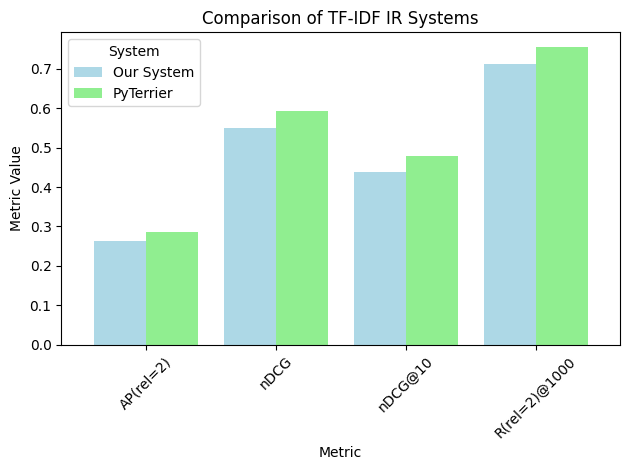

<Figure size 1000x600 with 0 Axes>

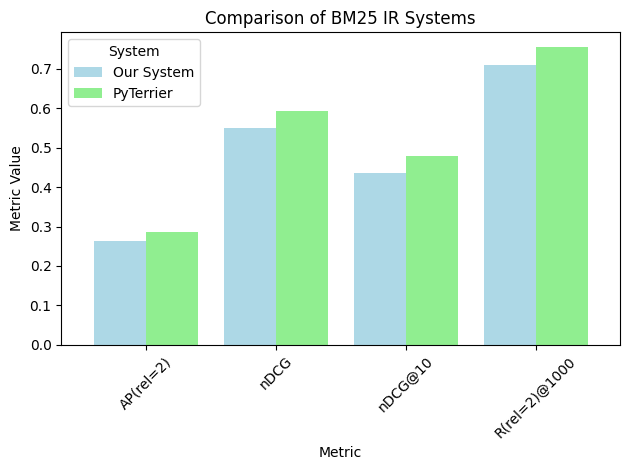

In [57]:
import matplotlib.pyplot as plt

#metrics = [AP(rel=2), nDCG, nDCG@10, Recall(rel=2)@1000]

# Example for one scoring function (TF-IDF)
for func in scoring_functions:
    # Prepare data for barplot
    comparison_df = pd.DataFrame({
        'Metric': metrics,
        'System': [system_measures[func].get(m, None) for m in metrics],
        'PyTerrier': [pyterrier_measures[func].get(m, None) for m in metrics]
    })

    # Set plot size and style
    plt.figure(figsize=(10, 6))
    comparison_df.set_index('Metric').plot(kind='bar', width=0.8, color=['lightblue', 'lightgreen'])
    
    plt.title(f'Comparison of {func} IR Systems')
    plt.ylabel('Metric Value')
    plt.xlabel('Metric')
    plt.xticks(rotation=45)
    plt.legend(title='System', labels=['Our System', 'PyTerrier'])
    plt.tight_layout()
    plt.show()


# Evaluating baselines (significance testing, paired $t$-test, 𝑝 < 0.05)

In [41]:
from scipy.stats import ttest_rel
import numpy as np

metrics = [AP(rel=2), nDCG, nDCG@10, Recall(rel=2)@1000]

def evaluate_baseline(metric, baseline_index = 0):
    # Baseline Index: 0 for TF-IDF, 1 for BM25
    
    # Compute per-topic AP scores for both TFIDF and BM25
    tfidf_scores = {}
    bm25_scores = {}

    for res in ir_measures.iter_calc([metric], qrels, run_file_tfidf):
        tfidf_scores[res.query_id] = res.value

    for res in ir_measures.iter_calc([metric], qrels, run_file_bm25):
        bm25_scores[res.query_id] = res.value

    # Ensure we have common queries
    common_queries = set(tfidf_scores.keys()).intersection(bm25_scores.keys())

    tfidf_list = [tfidf_scores[q] for q in common_queries]
    bm25_list = [bm25_scores[q] for q in common_queries]

    # Perform paired t-test
    t_stat, p_val = ttest_rel(tfidf_list, bm25_list)

    # Compute mean AP for each system
    mean_tfidf = np.mean(tfidf_list)
    mean_bm25 = np.mean(bm25_list)

    # Compute additional metrics relative to baseline
    if baseline_index == 0:  # TF-IDF is baseline
        baseline_name = "TF-IDF"
        compare_name = "BM25"
        plus = sum(1 for tf, bm in zip(tfidf_list, bm25_list) if bm > tf)
        minus = sum(1 for tf, bm in zip(tfidf_list, bm25_list) if bm < tf)
        baseline = mean_tfidf
        compare = mean_bm25
    else:  # BM25 is baseline
        baseline_name = "BM25"
        compare_name = "TF-IDF"
        plus = sum(1 for tf, bm in zip(tfidf_list, bm25_list) if tf > bm)
        minus = sum(1 for tf, bm in zip(tfidf_list, bm25_list) if tf < bm)
        baseline = mean_bm25
        compare = mean_tfidf

    # Create the DataFrame to match the desired output
    df_results = pd.DataFrame({
        'name': [baseline_name, compare_name],
        str(metric) : [baseline, compare],
        str(metric)+' +': [np.nan, plus],  # + only for the non-baseline system
        str(metric)+' -': [np.nan, minus],  # - only for the non-baseline system
        'p-value': [np.nan, p_val]
    })

    # Round values for better readability
    df_results = df_results.round(decimals)

    # Display the output
    print(df_results)


In [42]:
evaluate_baseline(AP(rel=2))

     name  AP(rel=2)  AP(rel=2) +  AP(rel=2) -  p-value
0  TF-IDF      0.263          NaN          NaN      NaN
1    BM25      0.263          1.0          2.0    0.349


In [43]:
evaluate_baseline(nDCG)

     name  nDCG  nDCG +  nDCG -  p-value
0  TF-IDF  0.55     NaN     NaN      NaN
1    BM25  0.55     2.0     1.0    0.655


In [44]:
evaluate_baseline(nDCG@10)

     name  nDCG@10  nDCG@10 +  nDCG@10 -  p-value
0  TF-IDF    0.437        NaN        NaN      NaN
1    BM25    0.437        0.0        0.0      NaN


In [45]:
evaluate_baseline(Recall(rel=2)@1000)

     name  R(rel=2)@1000  R(rel=2)@1000 +  R(rel=2)@1000 -  p-value
0  TF-IDF          0.711              NaN              NaN      NaN
1    BM25          0.710              0.0              1.0    0.323


# PyTerrier evaluating baselines (significance testing, paired $t$-test)

In [46]:
# comparation among TF-IDF and BM25 using PyTerrier (maybe not useful for our project)

pt.Experiment(
    [TF_IDF, BM25],
    queries_pt,
    qrels_pt,
    eval_metrics=[metric for metric in metrics],
    names=scoring_functions,
    round=3,
    baseline=0,
    save_dir='./'
    #save_mode="overwrite"
)

c:\Users\giuli\miniconda3\envs\mircv\lib\site-packages\pyterrier\pipelines.py:185: UserWarning: save_dir is set, but the file './TF-IDF.res.gz' already exists. If you are aware of are happy to reuse this file to speed up evaluation, set save_mode='reuse'; if you want to overwrite it, set save_mode='overwrite'. To make this condition an error, use save_mode='error'.
  warn(("save_dir is set, but the file '%s' already exists. If you are aware of are happy to reuse this " % save_file)+
c:\Users\giuli\miniconda3\envs\mircv\lib\site-packages\pyterrier\pipelines.py:185: UserWarning: save_dir is set, but the file './BM25.res.gz' already exists. If you are aware of are happy to reuse this file to speed up evaluation, set save_mode='reuse'; if you want to overwrite it, set save_mode='overwrite'. To make this condition an error, use save_mode='error'.
  warn(("save_dir is set, but the file '%s' already exists. If you are aware of are happy to reuse this " % save_file)+


,name,nDCG,nDCG@10,AP(rel=2),R(rel=2)@1000,nDCG +,nDCG -,nDCG p-value,nDCG@10 +,nDCG@10 -,nDCG@10 p-value,AP(rel=2) +,AP(rel=2) -,AP(rel=2) p-value,R(rel=2)@1000 +,R(rel=2)@1000 -,R(rel=2)@1000 p-value
0,TF-IDF,0.593,0.478,0.286,0.755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25,0.593,0.480,0.286,0.755,19.0,18.0,0.460364,2.0,2.0,0.419534,17.0,16.0,0.65963,2.0,0.0,0.169991


In [47]:
perquery_results = pt.Experiment(
    [TF_IDF, BM25],
    queries_pt,
    qrels_pt,
    eval_metrics=[metric for metric in metrics],
    names=scoring_functions,
    round=3,
    perquery=True
)

c:\Users\giuli\miniconda3\envs\mircv\lib\site-packages\pyterrier\pipelines.py:133: UserWarning: 157 topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.
  warn(f'{backfill_count} topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.')
c:\Users\giuli\miniconda3\envs\mircv\lib\site-packages\pyterrier\pipelines.py:133: UserWarning: 157 topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.
  warn(f'{backfill_count} topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.')


In [48]:
# print results that have value field not NaN
print(perquery_results[perquery_results['value'].notna()])

       name      qid        measure  value
836    BM25  1037798           nDCG  0.433
837    BM25  1037798        nDCG@10  0.153
838    BM25  1037798      AP(rel=2)  0.091
839    BM25  1037798  R(rel=2)@1000  1.000
884    BM25   104861           nDCG  0.731
..      ...      ...            ...    ...
43   TF-IDF   915593  R(rel=2)@1000  1.000
52   TF-IDF   962179           nDCG  0.401
53   TF-IDF   962179        nDCG@10  0.000
54   TF-IDF   962179      AP(rel=2)  0.050
55   TF-IDF   962179  R(rel=2)@1000  1.000

[344 rows x 4 columns]


# Significance testing, paired $t$-test among our system and PyTerrier

In [49]:
import pandas as pd
from scipy.stats import ttest_rel
import numpy as np
import ir_measures
from ir_measures import AP, nDCG, Recall

def compare_systems_detailed(perquery_results, my_system_run, qrels, metrics, scoring_function):
    """
    Compare a scoring function (BM25 or TF-IDF) between your system and PyTerrier using paired t-tests.

    Args:
        perquery_results (pd.DataFrame): PyTerrier per-query results DataFrame.
        my_system_run: Path to your system's run file.
        qrels: Ground truth relevance judgments.
        metrics (list): List of metrics to evaluate (e.g., [AP(rel=2), nDCG()]).
        scoring_function (str): Name of the scoring function ("BM25" or "TF-IDF").

    Returns:
        pd.DataFrame: DataFrame with detailed comparison results for all metrics.
    """
    # Filter PyTerrier per-query results for the scoring function
    pyterrier_results = perquery_results[perquery_results['name'] == scoring_function]

    # Prepare my system's per-query scores
    system_scores = {str(metric): {} for metric in metrics}
    for metric in metrics:
        for res in ir_measures.iter_calc([metric], qrels, my_system_run):
            system_scores[str(metric)][res.query_id] = res.value

    # Prepare data for detailed output
    results = {'name': [f"PyTerrier {scoring_function}", f"OurSystem {scoring_function}"]}

    for metric in metrics:
        metric_name = str(metric)

        # Extract PyTerrier per-query scores for this metric
        pyterrier_metric_scores = pyterrier_results[pyterrier_results['measure'] == metric_name]

        # Ensure only queries present in both systems are compared
        common_queries = set(pyterrier_metric_scores['qid']).intersection(
            system_scores[metric_name].keys()
        )

        # Extract scores for the common queries
        pyterrier_list = [
            pyterrier_metric_scores[pyterrier_metric_scores['qid'] == q]['value'].values[0]
            for q in common_queries
        ]
        system_list = [system_scores[metric_name][q] for q in common_queries]

        # Calculate paired t-test
        t_stat, p_val = ttest_rel(system_list, pyterrier_list)

        # Compute mean scores
        mean_pyterrier = np.mean(pyterrier_list)
        mean_mysystem = np.mean(system_list)

        # Additional metrics     
        plus = sum(1 for m, p in zip(system_list, pyterrier_list) if m > p)
        minus = sum(1 for m, p in zip(system_list, pyterrier_list) if m < p)

        # Add results for this metric
        results[metric_name] = [mean_pyterrier, mean_mysystem]
        results[f"{metric_name} +"] = [np.nan, plus]
        results[f"{metric_name} -"] = [np.nan, minus]
        results[f"{metric_name} p-value"] = [np.nan, p_val]

    # Create DataFrame
    df_results = pd.DataFrame(results)
    df_results = df_results.round(decimals)

    return df_results


In [50]:
# Define metrics for evaluation
metrics = [AP(rel=2), nDCG(), nDCG@10, Recall(rel=2)@1000]

# Call the function to compare systems
df_results = compare_systems_detailed(
    perquery_results=perquery_results,
    my_system_run=run_file_tfidf,
    qrels=qrels,
    metrics=metrics,
    scoring_function="TF-IDF"  # Change to "TF-IDF" if needed
)

# Display the detailed results
print(df_results)

               name  AP(rel=2)  AP(rel=2) +  AP(rel=2) -  AP(rel=2) p-value  \
0  PyTerrier TF-IDF      0.286          NaN          NaN                NaN   
1  OurSystem TF-IDF      0.263         16.0         26.0                0.1   

    nDCG  nDCG +  nDCG -  nDCG p-value  nDCG@10  nDCG@10 +  nDCG@10 -  \
0  0.593     NaN     NaN           NaN    0.478        NaN        NaN   
1  0.550    16.0    27.0         0.016    0.437       14.0       27.0   

   nDCG@10 p-value  R(rel=2)@1000  R(rel=2)@1000 +  R(rel=2)@1000 -  \
0              NaN          0.755              NaN              NaN   
1            0.144          0.711             13.0             15.0   

   R(rel=2)@1000 p-value  
0                    NaN  
1                  0.077  


In [51]:
# Define metrics for evaluation
metrics = [AP(rel=2), nDCG(), nDCG@10, Recall(rel=2)@1000]

# Call the function to compare systems
df_results = compare_systems_detailed(
    perquery_results=perquery_results,
    my_system_run=run_file_bm25,
    qrels=qrels,
    metrics=metrics,
    scoring_function="BM25"  # Change to "TF-IDF" if needed
)

# Display the detailed results
print(df_results)

             name  AP(rel=2)  AP(rel=2) +  AP(rel=2) -  AP(rel=2) p-value  \
0  PyTerrier BM25      0.286          NaN          NaN                NaN   
1  OurSystem BM25      0.263         16.0         26.0              0.104   

    nDCG  nDCG +  nDCG -  nDCG p-value  nDCG@10  nDCG@10 +  nDCG@10 -  \
0  0.593     NaN     NaN           NaN    0.480        NaN        NaN   
1  0.550    14.0    29.0         0.016    0.437       14.0       27.0   

   nDCG@10 p-value  R(rel=2)@1000  R(rel=2)@1000 +  R(rel=2)@1000 -  \
0              NaN          0.755              NaN              NaN   
1            0.133          0.710             13.0             15.0   

   R(rel=2)@1000 p-value  
0                    NaN  
1                  0.071  


# Trying it out

In [52]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import time


# UI elements
search_bar = widgets.Text(
    placeholder='Type in a query...',
    description='Search:',
    layout=widgets.Layout(width='80%')
)
search_button = widgets.Button(
    description='Search',
    button_style='success',
    tooltip='Execute the query',
    icon='search'
)

score_function_rbtn = widgets.RadioButtons(options=['TF-IDF', 'BM25'], description='Scoring function:', disabled=False)
algo_rbtn = widgets.RadioButtons(options=['TAAT', 'DAAT'], description='Algorithm:', disabled=False)
_style = widgets.HTML(
    "<style>.widget-radio-box {flex-direction: row !important;}.widget-radio-box"
    " label{margin:2px !important;width: 100px !important;}</style>",
    layout=widgets.Layout(display="none"),
)

output_area = widgets.Output()


def on_search_click(b):
    with output_area:
        clear_output()  # clean previous output
        query = search_bar.value
        if not query.strip():
            print("Please, type in a query.")
            return
        
        selected_scoring_function = score_function_rbtn.value
        print(f"Selected scoring function: {selected_scoring_function}")
        if selected_scoring_function == 'TF-IDF':
            method = 'tfidf'
        else:   
            method = 'bm25'

        selected_algorithm = algo_rbtn.value
        print(f"Selected Algorithm: {selected_algorithm}")
        
        start_time = time.time()
        # --- QUERY EXECUTION ---
        processed_query = preprocess(query)
        termids = inv_index.get_termids(processed_query)
        postings = inv_index.get_postings(termids)
        
        if selected_algorithm == 'TAAT':
            results = taat(postings, method=method)
        else:
            results = daat(postings, method=method)
        # ------------------------
        elapsed_time = (time.time() - start_time) * 1000 # convert in ms

        # finally show the results
        print(f"Found: {len(results)} documents\n")
        for res in results:
            res = (round(res[0], 4), res[1]) # TODO : si potrebbe spostare direttamente nella score function
            print(f" - {res}")
        print(f"\nExecution time: {elapsed_time:.2f} ms")

search_button.on_click(on_search_click)
# link search button to the enter key
search_bar.continuous_update = False
search_bar.observe(on_search_click, names='value')

top_row = widgets.HBox([score_function_rbtn,_style])
middle_row = widgets.HBox([algo_rbtn,_style])
bottom_row = widgets.HBox([search_bar, search_button])

# finally display the UI
display(widgets.VBox([top_row,middle_row, bottom_row]))
display(output_area)


Output()